In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


In [2]:
# EXPERIMENT PARAMS
from pyfrac.hydrafrac.acquisition import recgeom,rec2das_datatrnsfrm,dasgeom

# LOCATION
from pyfrac.pseudodas.receiveroperators import cubePDoperator
from pyfrac.imaging.kirchhoff import Kirchhoff
from pyfrac.utils.localisationutils import get_max_locs

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage
from pyfrac.visualisation.eventimages import locimage3d

# SETUP - MODEL, REC GEOM, SOURCES

In [3]:
# Velocity Model
nx, ny, nz = 50, 50, 50
dx, dy, dz = 4, 4, 4
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

v0 = 1000 # initial velocity
kv = 0. # gradient
vel = np.outer(np.ones(nx), v0 +kv*z) 

In [4]:
# RECEIVERS
nxyz = [nx, ny, nz]
dxyz = [dx, dy, dz]
gridded_recs, nr, rec_string = recgeom(nxyz, dxyz)
print (nr, gridded_recs.shape)

150 (3, 150)


In [5]:
# Microseismic sources
sx, sy, sz = [nx//4, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

# MAKE DATA

In [6]:
nt = 251
dt = 0.004
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:41], f0=20)

In [7]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=gridded_recs[:, :1], 
               recs=gridded_recs, 
               vel=v0, 
               wav=wav, 
               wavcenter=wavc, 
               mode='analytic', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=2499.8480663225896 - u^H(Op^Hv)=2499.8480663226137


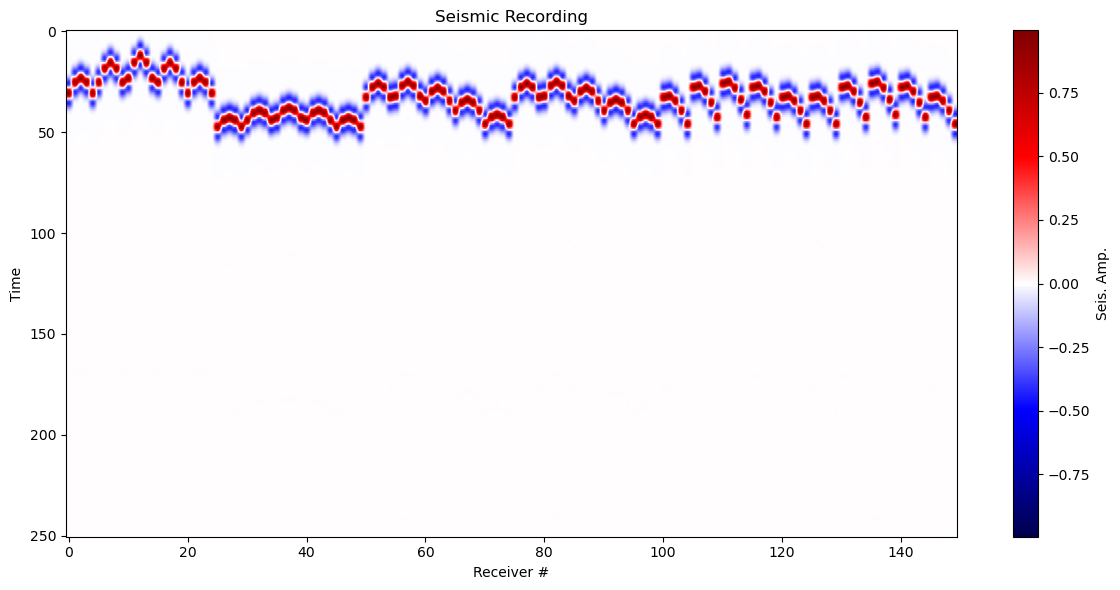

In [8]:
# PERFORM FORWARD (MODEL)
frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)
fig,ax = traceimage(frwddata, climQ=99.99)

# MIGRATE

Hypo Center: [12 25 25]


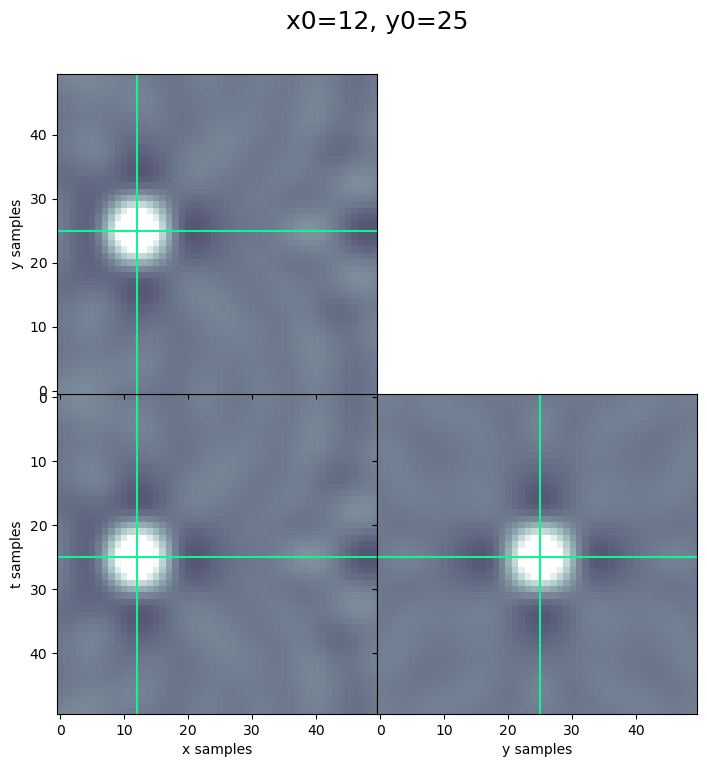

In [9]:
migrated = (Op.H @ frwddata).reshape(nx,ny,nz)
hc =  get_max_locs(migrated, n_max=1, rem_edge=False)
print('Hypo Center:',hc.flatten())
fig,axs = locimage3d(migrated,sx,sy)

# INVERSION

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 37650 rows and 125000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   2.309e+01  2.309e+01    1.0e+00  1.3e+01
     1  8.00013e-05   1.147e+01  1.147e+01    5.0e-01  7.2e-01   3.6e+02  1.0e+00
     2  4.72333e-05   7.777e+00  7.777e+00    3.4e-01  4.0e-01   5.2e+02  2.2e+00
     3  7.53749e-05   5.799e+00  5.799e+00    2.5e-01  2.7e-01   6.4e+02  3.6e+00
     4  5.14853e-05   4.651e+00  4.651e+00    2.0e-01  2.1e-01   7.3e+02  5.1e+00
     5  4.55320e-05   3.895e+00  3.895e+00    1.7e-01  2.0e-01   8.0e+02  6.8e+00
     6  2.62876e-05   3.268e+00  3.268e+00    1.4e-01  1.5e-01   8.9e+02  8.9e+00
     7  2.46783e-05   2.808e+00  2.808e+00    1.2e-01  1.4e-01   9.5e+02  1.1e+01
     8  2.75605e-05   2.468e+00

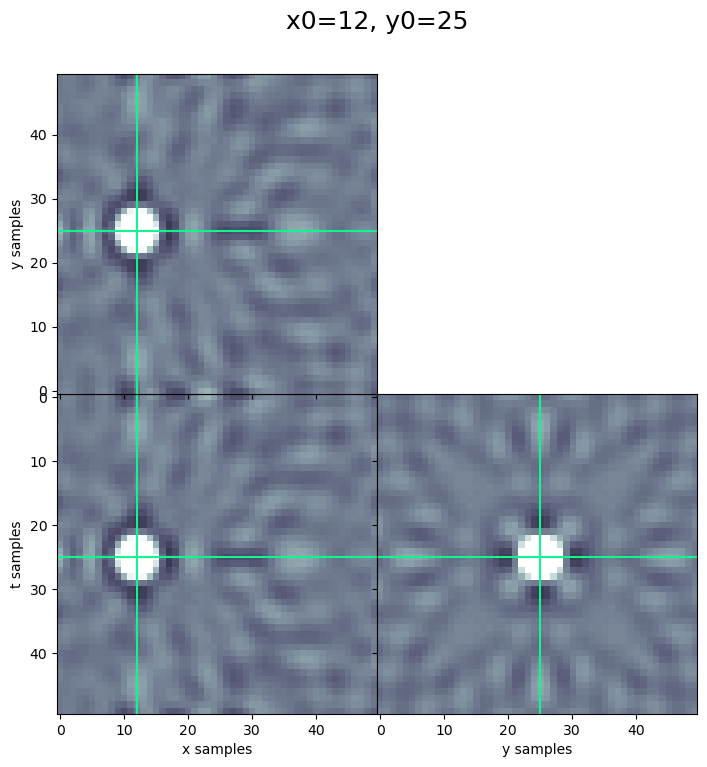

In [10]:
inv = (lsqr(Op, frwddata.ravel(), iter_lim=100, show=True)[0]).reshape(nx,ny,nz)
hc =  get_max_locs(inv, n_max=1, rem_edge=False)
print('Hypo Center:',hc.flatten())
fig,axs = locimage3d(inv,sx,sy)

# PSEUDO-DAS

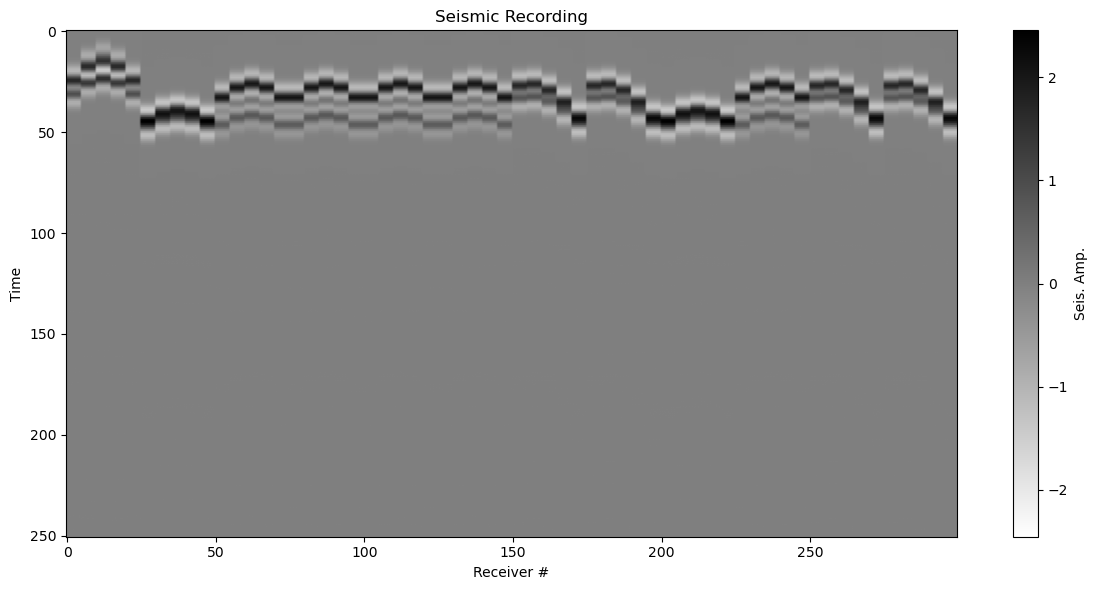

In [11]:
nr_x = 5
pdas_recs = dasgeom(nxyz, dxyz)
pdas_data = rec2das_datatrnsfrm(frwddata, [nr_x, nr_x, nr_x], nt)
fig,ax = traceimage(pdas_data, climQ=99.99, cmap='binary')

In [12]:
SumStackOp = cubePDoperator(nr_x, nt)
pdasFrwdOp = SumStackOp * Op

In [13]:
pdas_Ev = pdasFrwdOp @ microseismic.flatten()

Hypo Center: [12 25 25]


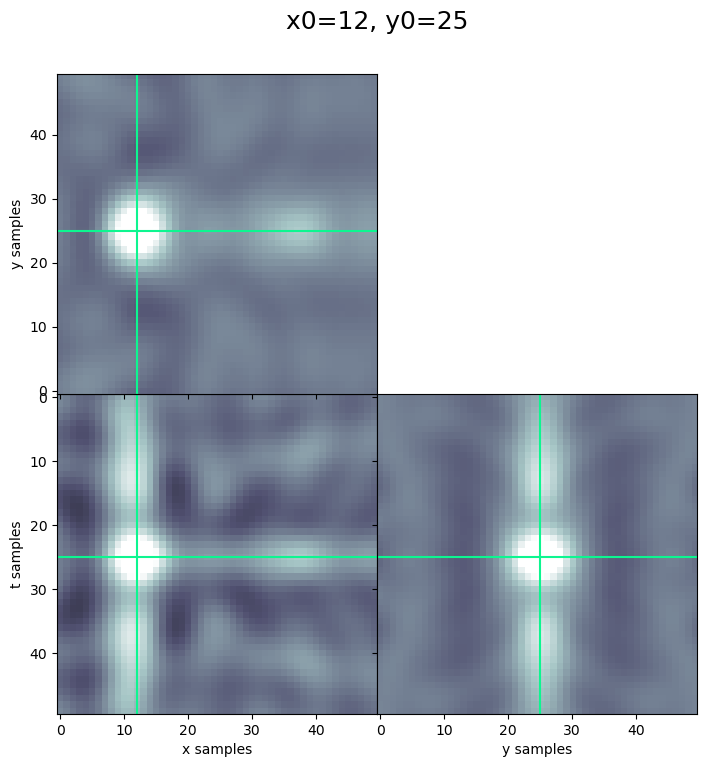

In [14]:
pdas_migration = (pdasFrwdOp.H @ pdas_Ev.ravel()).reshape(nx,ny,nz)
hc =  get_max_locs(pdas_migration, n_max=1, rem_edge=False)
print('Hypo Center:',hc.flatten())
fig,axs = locimage3d(pdas_migration,sx,sy)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 75300 rows and 125000 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      100
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   7.894e+01  7.894e+01    1.0e+00  2.5e+01
     1  3.28431e-05   3.733e+01  3.733e+01    4.7e-01  6.8e-01   2.2e+03  1.0e+00
     2  3.55808e-05   2.473e+01  2.473e+01    3.1e-01  3.7e-01   3.1e+03  2.2e+00
     3  1.70071e-05   1.814e+01  1.814e+01    2.3e-01  2.8e-01   3.7e+03  3.6e+00
     4  8.64853e-06   1.385e+01  1.385e+01    1.8e-01  2.2e-01   4.1e+03  5.2e+00
     5  1.06536e-05   1.159e+01  1.159e+01    1.5e-01  1.7e-01   4.6e+03  6.8e+00
     6  1.10867e-05   9.837e+00  9.837e+00    1.2e-01  1.4e-01   5.0e+03  8.7e+00
     7  1.16268e-05   8.475e+00  8.475e+00    1.1e-01  1.3e-01   5.3e+03  1.1e+01
     8  2.73200e-06   7.363e+00

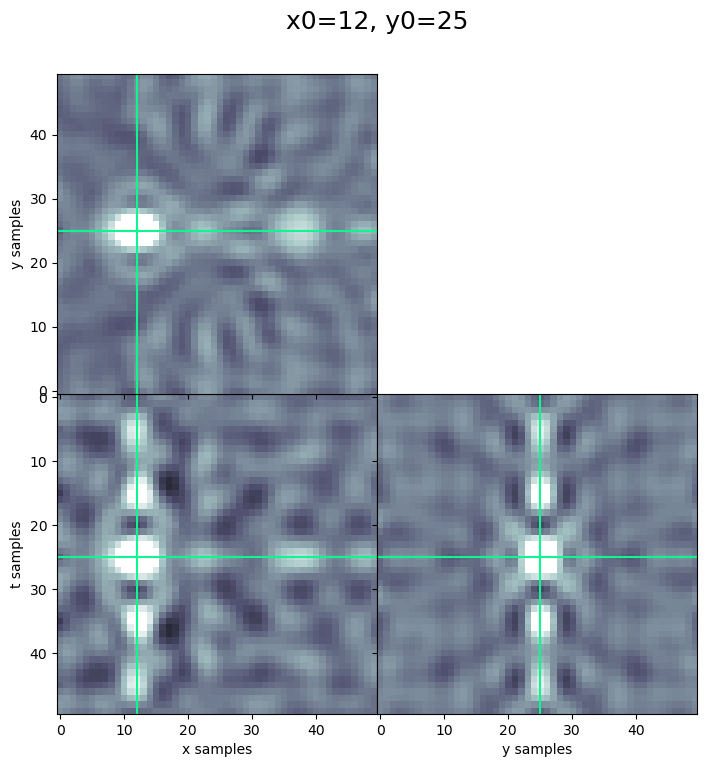

In [15]:
pdas_lsqr = lsqr(pdasFrwdOp, pdas_Ev.flatten(), iter_lim=100, show=True)[0].reshape(nx,ny,nz)
hc =  get_max_locs(pdas_lsqr, n_max=1, rem_edge=False)
print('Hypo Center:',hc.flatten())
fig,axs = locimage3d(pdas_lsqr,sx,sy)

FISTA (soft thresholding)
--------------------------------------------------------------------------------
The Operator Op has 75300 rows and 125000 cols
eps = 1.000000e+02	tol = 1.000000e-10	niter = 100
alpha = 1.322941e-07	thresh = 6.614706e-06
--------------------------------------------------------------------------------
   Itn          x[0]              r2norm     r12norm     xupdate
     1       1.4598e-05         1.065e+03   1.399e+03   1.909e-02
     2       1.5668e-05         6.147e+02   1.038e+03   8.183e-03
     3       1.0125e-05         3.954e+02   8.715e+02   6.348e-03
     4       0.0000e+00         2.826e+02   7.857e+02   5.029e-03
     5      -5.2430e-07         2.180e+02   7.318e+02   4.197e-03
     6      -0.0000e+00         1.767e+02   6.920e+02   3.683e-03
     7      -0.0000e+00         1.483e+02   6.592e+02   3.364e-03
     8      -0.0000e+00         1.279e+02   6.304e+02   3.155e-03
     9      -0.0000e+00         1.127e+02   6.039e+02   3.013e-03
    10      -

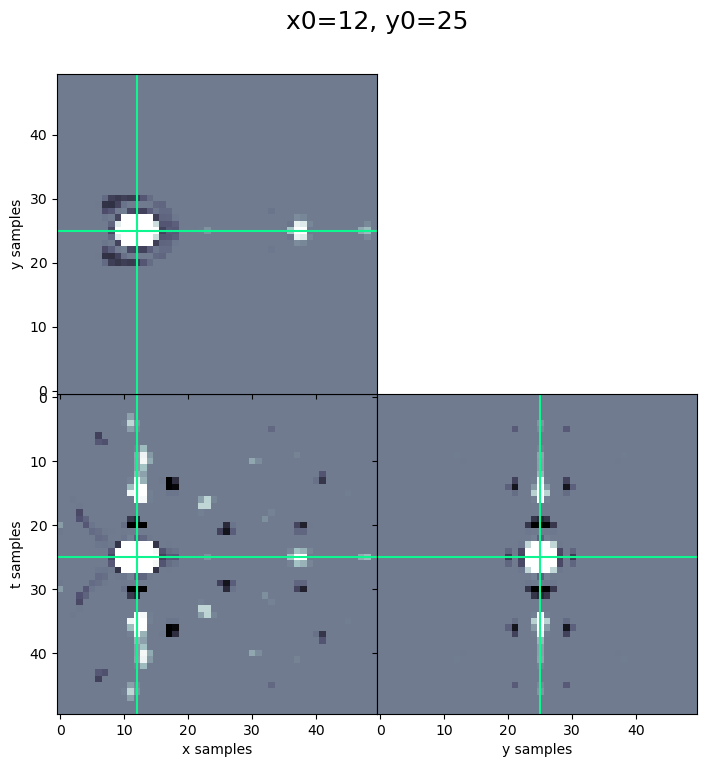

In [16]:
with pylops.disabled_ndarray_multiplication():
    pdas_fista = fista(pdasFrwdOp, pdas_Ev.flatten(), niter=100, eps=1e2, show=True)[0].reshape(nx,ny,nz)
hc =  get_max_locs(pdas_fista, n_max=1, rem_edge=False)
print('Hypo Center:',hc.flatten())
fig,axs = locimage3d(pdas_fista,sx,sy)